# Raport

I'm working on the Heart Attack dataset.
Short description of variables:
* `age`: The person's age in years
* `sex`: The person's sex
  * 1: male
  * 0: female
* `cp`: chest pain type
  * 0: asymptomatic
  * 1: atypical angina
  * 2: non-anginal pain
  * 3: typical angina
* `trtbps`: The person's resting blood pressure (mm Hg on admission to the hospital)
* `chol`: The person's cholesterol measurement in mg/dl
* `fbs`: The person's fasting blood sugar (> 120 mg/dl)
  * 1: true
  * 0: false
* `restecg`: Resting electrocardiographic measurement
  * 0: showing probable or definite left ventricular hypertrophy by Estes' criteria
  * 1: normal
  * 2: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
* `thalachh`: The person's maximum heart rate achieved
* `exng`: Exercise induced angina
  * 1: true
  * 0: false
* `oldpeak`: ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot.)
* `slp`: the slope of the peak exercise ST segment
  * 0: downsloping
  * 1: flat
  * 2: upsloping
* `caa`: The number of major vessels (0-3) colored by fluoroscopy
* `thall`: Results of the blood flow observed via the radioactive dye
  * 0: NULL (dropped from the dataset previously)
  * 1: fixed defect (no blood flow in some part of the heart)
  * 2: normal blood flow
  * 3: reversible defect (a blood flow is observed but it is not normal)
* `output`: Heart disease (target)
  * 0: disease
  * 1: no disease

 ## 1.

The variables of the highest importance are `caa`, `oldpeak`, and `cp_0`.
![](https://drive.google.com/uc?export=view&id=1TKfbs0ZuTC0kgDPDehNxbgl_qwfmC6rE)

## 2.

I created 3 more models - logistic regression and 2 xgb models with larger `max_depth` parameter which is equal to `5` and `10`, respectively. This parameter in the baseline model was set to `2`.

![](https://drive.google.com/uc?export=view&id=17SzLh435P_lsHAsqQeKlb-vIjiN-jTzY)
![](https://drive.google.com/uc?export=view&id=1QHO5Pr1yBC2PfxmlffMUp32Y98ZXWwFo)
![](https://drive.google.com/uc?export=view&id=1q4dei2BRl81hocIP4A-SQFm-EWNeM4RU)

In all 4 models the most important variable is `caa` (The number of major vessels colored by fluoroscopy). However, order and importance of next variables vary significantly. The choice of model and hyperparameters affects variables' importance in a substantial manner. In the case of the XGB models one can see that the deeper model gets the more sparse variables' importance is. In other words, it tends to assign significant importance to fewer variables.

## 3.

### a)

![](https://drive.google.com/uc?export=view&id=1Sw44xZ5dwkvW1M1-_rN6tffrPn-rIdNt)

Gini impurity in this case seems highly inconsistent with the PVI from task 1. 

### b)
![](https://drive.google.com/uc?export=view&id=1wKm8Lmc4SuzeWcRZvP5XbCogU0C2kpwB)

For the SHAP tree method, which makes use of Shapley Value, the most important factor influencing model performance is variable `caa`, the number of major vessels. This is the case for almost every model presented in this notebook. Other most important variables, such as `cp_0` and `thall_2` are similarly important across different models, results are quite consistent.

# Appendix

## Import packages

In [1]:
!pip install dalex &>/dev/null
!pip install lime &>/dev/null
!pip install shap &>/dev/null

In [2]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix,\
  ConfusionMatrixDisplay, f1_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
import dalex as dx
import lime
import shap

SEED = 42

## Load data

In [3]:
!gdown 14RnHkHVRmZHdXF7_THt7arQzlzplKbF1

Downloading...
From: https://drive.google.com/uc?id=14RnHkHVRmZHdXF7_THt7arQzlzplKbF1
To: /content/heart.csv
100% 11.3k/11.3k [00:00<00:00, 17.7MB/s]


In [4]:
df_raw = pd.read_csv('heart.csv')
df_raw.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## Data preprocessing

In [5]:
df_raw.info() # only int and float

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [6]:
print(df_raw.shape) # 303 observations, 14 variables (including one output class)
df_raw.describe()

(303, 14)


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


Based on the data and documentation from kaggle we should apply one-hot encoding transformation to the following variables: `cp`, `restecg`, `slp` and `thall`.

In [7]:
df = pd.get_dummies(df_raw, columns=['cp', 'restecg', 'slp', 'thall'])
df.head()

,age,sex,trtbps,chol,fbs,thalachh,exng,oldpeak,caa,output,...,restecg_0,restecg_1,restecg_2,slp_0,slp_1,slp_2,thall_0,thall_1,thall_2,thall_3
0,63,1,145,233,1,150,0,2.3,0,1,...,1,0,0,1,0,0,0,1,0,0
1,37,1,130,250,0,187,0,3.5,0,1,...,0,1,0,1,0,0,0,0,1,0
2,41,0,130,204,0,172,0,1.4,0,1,...,1,0,0,0,0,1,0,0,1,0
3,56,1,120,236,0,178,0,0.8,0,1,...,0,1,0,0,0,1,0,0,1,0
4,57,0,120,354,0,163,1,0.6,0,1,...,0,1,0,0,0,1,0,0,1,0


In [8]:
X = df.drop('output', axis=1)
y = df.output

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

With stratify argument we can assure than the proportion of values in the sample produced will be the same as the proportion of values in `y`.

Also, I decided to standardize features by removing the mean and scaling to unit variance. We don't want a feature that has a variance that is orders of magnitude larger than others.

For now I will use just train/test split, in the future I can extend it with train/val/test split if needed.

## Train a XGBoost model

In [13]:
BST_model = xgb.XGBClassifier(random_state=SEED, max_depth=2).fit(X, y)

## Evaluate model on some examples

In [11]:
pf_xgboost_classifier_default = lambda m, d: m.predict_proba(d)[:, 1]
BST_explainer = dx.Explainer(BST_model, X, y, predict_function=pf_xgboost_classifier_default, label="GBM")

Preparation of a new explainer is initiated

  -> data              : 303 rows 23 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 303 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : GBM
  -> predict function  : <function <lambda> at 0x7fd5d4376160> will be used
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.00365, mean = 0.544, max = 0.995
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.929, mean = 0.000168, max = 0.836
  -> model_info        : package xgboost

A new explainer has been created!


Check performance

In [12]:
BST_explainer.model_performance()

,recall,precision,f1,accuracy,auc
GBM,0.933333,0.905882,0.919403,0.910891,0.978788


In [13]:
pvi_BST = BST_explainer.model_parts(random_state=SEED)
pvi_BST.result

,variable,dropout_loss,label
0,restecg_0,0.021012,GBM
1,_full_model_,0.021212,GBM
2,thall_0,0.021212,GBM
3,cp_1,0.021212,GBM
4,cp_3,0.021212,GBM
5,restecg_2,0.021212,GBM
6,cp_2,0.021230,GBM
7,thall_1,0.021313,GBM
8,fbs,0.021515,GBM
9,slp_0,0.021941,GBM


In [14]:
pvi_BST.plot(show=False).update_layout(autosize=False, width=600, height=450)

In [15]:
pvi_BST.plot(
    max_vars=3, 
    digits=4, 
    bar_width=40, 
    title="Permutation-based Variable Importance (Top 3)", 
    show=False
).update_layout(width=600)

## Train three more candidate models

Let's train 3 more models - logistic regression and 2 XGB models with larger `max_depth` parameter.

In [16]:
LR_model = LogisticRegression(random_state=SEED).fit(X, y)
BST_model_deep = xgb.XGBClassifier(random_state=SEED, max_depth=5, min_split_loss=2).fit(X, y)
BST_model_deeper = xgb.XGBClassifier(random_state=SEED, max_depth=10, min_split_loss=0).fit(X, y)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [17]:
LR_explainer = dx.Explainer(LR_model, X, y, predict_function=pf_xgboost_classifier_default, label="LR")
BST_deep_explainer = dx.Explainer(BST_model_deep, X, y, predict_function=pf_xgboost_classifier_default, label="GBM_deep")
BST_deeper_explainer = dx.Explainer(BST_model_deeper, X, y, predict_function=pf_xgboost_classifier_default, label="GBM_deeper")

Preparation of a new explainer is initiated

  -> data              : 303 rows 23 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 303 values
  -> model_class       : sklearn.linear_model._logistic.LogisticRegression (default)
  -> label             : LR
  -> predict function  : <function <lambda> at 0x7fd5d4376160> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.00145, mean = 0.543, max = 0.995
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.967, mean = 0.00121, max = 0.96
  -> model_info        : package sklearn

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 303 rows 23 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target vari

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names



Check performance

In [18]:
explainers_list = [BST_explainer, LR_explainer, BST_deep_explainer, BST_deeper_explainer]
for explainer in explainers_list:
    display(explainer.model_performance())

,recall,precision,f1,accuracy,auc
GBM,0.933333,0.905882,0.919403,0.910891,0.978788


,recall,precision,f1,accuracy,auc
LR,0.915152,0.857955,0.88563,0.871287,0.928722


,recall,precision,f1,accuracy,auc
GBM_deep,0.963636,0.929825,0.946429,0.940594,0.989284


,recall,precision,f1,accuracy,auc
GBM_deeper,1.0,1.0,1.0,1.0,1.0


In [19]:
for i, explainer in enumerate(explainers_list):
    pvi = explainer.model_parts(random_state=SEED)
    pvi.plot(show=False).update_layout(autosize=False, width=600, height=450, title=f'pvi{i}').show()

## Gini impurity

In [20]:
BST_model.feature_importances_

array([0.02491782, 0.02366763, 0.01549127, 0.02339969, 0.01152322,
       0.01995402, 0.0617747 , 0.03930507, 0.06111274, 0.1469555 ,
       0.        , 0.01667771, 0.        , 0.03268454, 0.02739064,
       0.        , 0.00513185, 0.04189407, 0.06097987, 0.        ,
       0.01269084, 0.34154585, 0.03290296], dtype=float32)

In [21]:
pd.DataFrame({'variable': X.columns, 'importance': BST_model.feature_importances_})

,variable,importance
0,age,0.024918
1,sex,0.023668
2,trtbps,0.015491
3,chol,0.023400
4,fbs,0.011523
5,thalachh,0.019954
6,exng,0.061775
7,oldpeak,0.039305
8,caa,0.061113
9,cp_0,0.146956


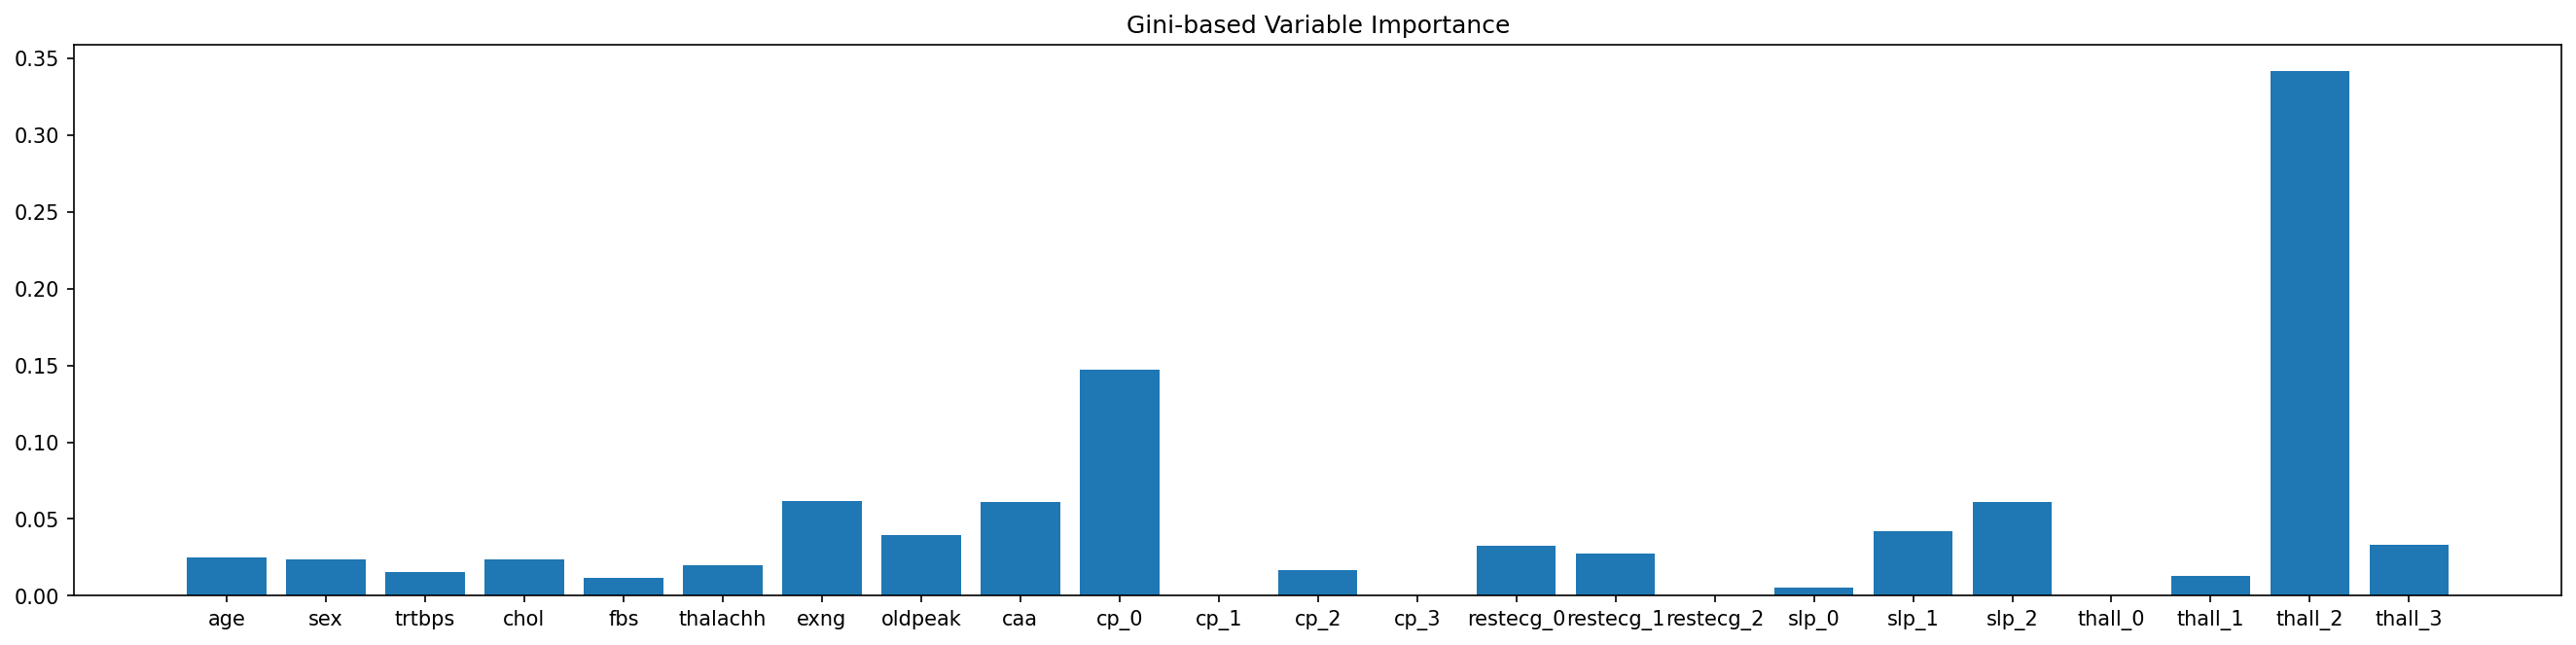

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(22, 5), dpi=150)
plt.bar(X.columns, BST_model.feature_importances_)
plt.title("Gini-based Variable Importance")
plt.show()

## ThreeSHAP

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22'] ['age', 'sex', 'trtbps', 'chol', 'fbs', 'thalachh', 'exng', 'oldpeak', 'caa', 'cp_0', 'cp_1', 'cp_2', 'cp_3', 'restecg_0', 'restecg_1', 'restecg_2', 'slp_0', 'slp_1', 'slp_2', 'thall_0', 'thall_1', 'thall_2', 'thall_3']
expected f0, f17, f1, f10, f19, f12, f21, f7, f3, f18, f16, f14, f9, f8, f5, f6, f13, f2, f20, f15, f4, f11, f22 in input data
training data did not have the following fields: slp_2, cp_1, cp_2, thall_2, thall_1, fbs, restecg_0, trtbps, exng, caa, thalachh, slp_0, chol, age, cp_0, oldpeak, thall_3, sex, thall_0, slp_1, restecg_1, cp_3, restecg_2


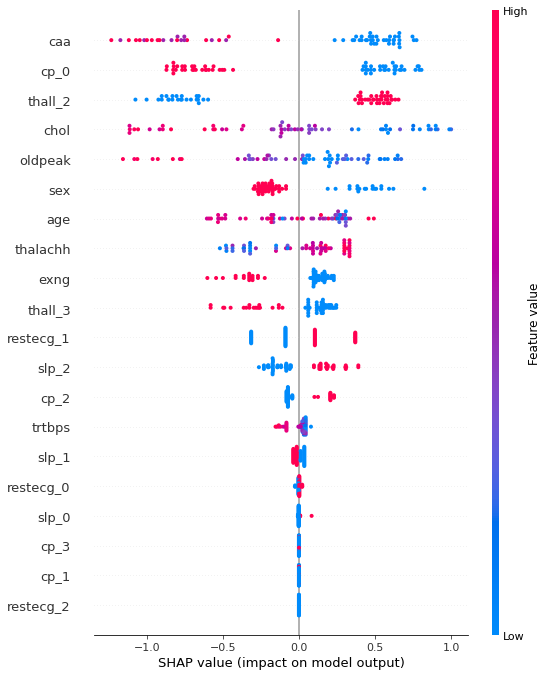

In [64]:
BST_model = xgb.XGBClassifier(random_state=SEED, max_depth=2).fit(X_train.values, y_train.values)
BST_explainer = dx.Explainer(BST_model, X_test, y_test, label="GBM", verbose=False)
shap_vi = BST_explainer.model_parts(type="shap_wrapper", shap_explainer_type="TreeExplainer", random_state=SEED)
shap_vi.plot()

---
---